In [5]:
from IPython.display import Image
from __future__ import division, print_function, absolute_import
from nltk.tokenize import word_tokenize
from nltk import ne_chunk
from nltk.corpus import sentiwordnet as swn
from collections import Counter
from autocorrect import spell
from string import punctuation
import tflearn
import numpy as np
import tensorflow as tf
from tflearn.data_utils import to_categorical, pad_sequences
from sentencetovector import MAX_SENTENCE_LENGHT, NUM_DICTIONARY_WORDS,\
    SentenceToVector
from getsentimentscore import GetSentenceAverageSentimentScore
import trainSubjectivityLSTM 
from tensorflow.python.framework import ops
np.set_printoptions(threshold=np.inf)

INFO:tensorflow:Restoring parameters from C:\Users\seyit\NLP Lab\model_subjectivity_lstm_2classes.tfl


<h2>1. Introduction</h2>
<p>Seniment analysis is one of the core topics of Natural Language Processing, and is yet to be solved once and for all for artificial intelligence systems. Since there are many parameters affecting the sentiment of a given text, ranging from the grammer used to the order of words, or from the subjectivity/objectivity to the inclusion of irony, this task still remains challenging and exciting. In this project, the problem to tackle revolves around predicting the polarity of reviews on [IMDB](https://www.imdb.com/) (The Internet Movie Database) where a review being positive means that it has the rating of [5, 10], or [0, 4] for being negative on a scale of [0, 10]. There are currently multifarious ways for attempting to solve this problem, and the model proposed makes use of combination of different types of currently popular artificial neural networks, namely Long-Short Term Memory (LSTM) and Convolutional Neural Networks (CNN). The model also benefits and explores SentiWordNet[[1](http://sentiwordnet.isti.cnr.it/)], a publicly available lexial resource for opinion mining, that assigns scores to each word based on the scales of positivity/negativity, and objectivity/subjectivity. Throughout the entire implementation, no research/conference papers or any existing models were followed, i.e., the model itself is a genuine attempt.</p>
<h2>2. The Proposed Model</h2>
<p>The general idea behind the proposed model is to detach each sentence from the given review, and create feature vectors of the review based on the polarity attribute obtained from each detached sentence. These feature vectors will henceforth be named as "sentiment maps", and each sentiment map can be thought of as 10x10 greyscale images. This step is the reason why CNNs were picked, as they are vey capable of image classification. In general, the model occupies an LSTM module, a SentiWordNet module and a CNN module. The rough workflow of the entire model after a review has been fed is as follows:</p>
<ol>
<li>detach sentences</li>
<li>for each of the sentences</li>
    <ol>
        <li>convert the sentence to its vector representation</li>
        <li>get the polarity (positive or negative) of the sentence using PolarityLSTM</li>
        <li>using the polarity obtained, calculate the average sentiment score of the words in the sentence through SentiWordNet</li>
        <li>insert the obtained sentiment score to the respective index of the sentence in the respective (i.e., positive or negative) sentiment map</li>
    </ol>
<li>after obtaining the positive and negative sentiment maps of the review, feed these maps to the CNN</li>
<li>let the CNN decide to which class (positive or negative) these sentiment maps of the given review belongs, ultimately predicting whether this review is positive or negative</li>
</ol>

Following figure shows the rough (sentiment maps are for example are not of the real scales) overlook of the model:

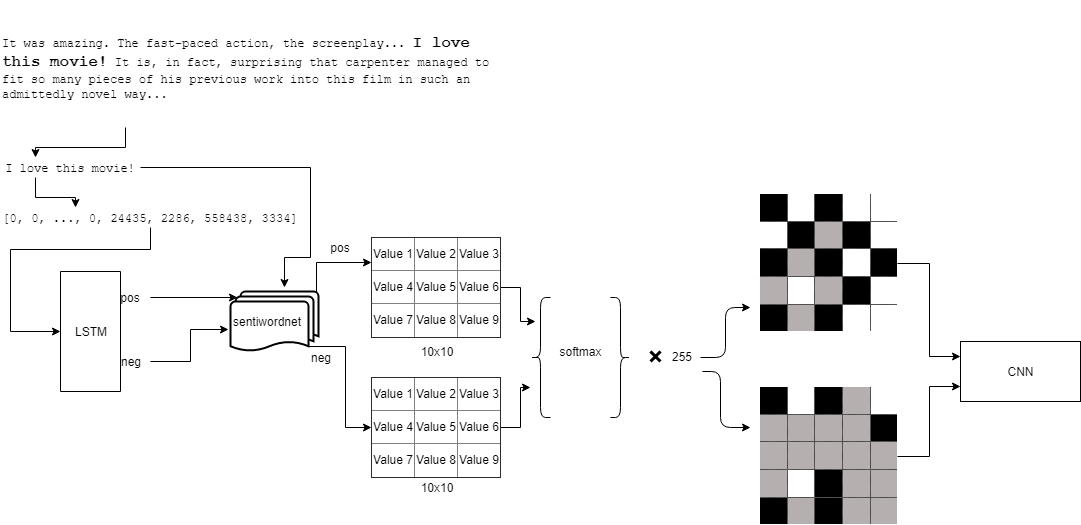

In [5]:
Image('overlook.png')

<p>Note that this whole workflow (and the model figure thereof) is the initial implementation, and through the results of testing and the "popped up" challenges faced during some of the steps, the entire model was somewhat modified. The modifications and the situations that led to the necessity of addition of them will be explained in detail in the rest of this report.</p> 

<h2>3. Walkthrough of Implementation</h2>
<p>This section is going to cover the details of implementation of every module present in the model. The aforementioned additions/modifications are also going to be explained. The machine learning library used was [`tflearn`](http://tflearn.org/), an excellent wrapper API for [`Tensorflow`](https://www.tensorflow.org/).</p>

<h3>3.1 LSTM Module</h3>
<h4>3.1.1 PolarityLSTM Architecture and Training</h4>
<p></p>For the training phase of the PolarityLSTM two compact datasets are used, all of which consist of sentences labelled as being positive or negative. The first dataset is the sentences obtained from [Rotten Tomatoes](https://www.rottentomatoes.com/), provided at [[2](http://www.cs.cornell.edu/people/pabo/movie-review-data)], it has 5000 positive and 5000 negative sentences. The second dataset is the sentences obtained from IMDB, Amazon and Yelp provided at [[3](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)], it has 1500 positive and 1500 negative sentences. Therefore, the total amount of data is 13000 sentences. </p>
<p>LSTMs require fixed length of sequences to work. Hence the numbers of words belonging to a sentence that can be fed to an LSTM has to be decided beforehand. Because of this, `MAX_SENTENCE_LENGTH` variable defined in `sentencetovector.py` was set to be `50`, which is a fairly adequate amount for any sentence. Apart from the length issue, LSTMs only work for real numbers, i.e., there is no way to feed strings to an LSTM. Thus, there has to be some kind of representation of each word as an integer, so that the word and the sentence it exists in can be expressed as a collection of integer values. For this purpose, a file that contains every existing word in the English language is used. The file `words.txt` bares ~470,000 words as a list, and before getting fed to the PolarityLSTM, each word in a sentence is converted into its integer representation, which is the very index in this file. However, before extracting the vector representation, each sentence is lowercased, stripped of the punctuation, and possible typos (if any) are somewhat corrected. Moreover, since each sentence is expected to have a fixed amount of words, the empty slots on the vector is padded with `0`s. 

In [9]:
sentence = "I love this movie!..."
sentence_with_typo = "I lovy this movie!..."
sentence_vector = SentenceToVector(sentence)
sentence_with_typo_vector = SentenceToVector(sentence_with_typo)
print(sentence_vector)
print()
print(sentence_with_typo_vector)

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 182747 222524 406064 246772]

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 182747 222524 406064 246772]


<p>The preprocessing of all of the datasets was carried on in `preprocessorLSTM.py`. After the preprocessing has been done, the definition of the LSTM model is made. An overall look of an unrolled LSTM network is as follows (image courtesy of [[4](https://stats.stackexchange.com/users/116850/mujjiga)]):</p>

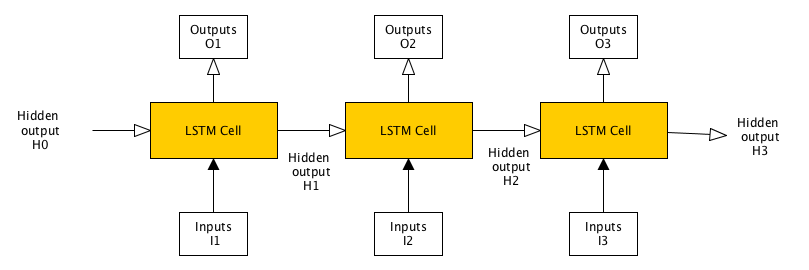

In [12]:
Image('unrolledlstmnetwork.png')

As can be seen from the figure, an LSTM network consist of LSTM cells that bare the necessary recurrent connections. Afterall, LSTMs are just speciallized cases of Recurrent Neural Networks. Since LSTM training is sequential, i.e., each cell accepts an input at every time step t, in our model there has to be theoratically `50` LSTM cells, one for each word. However, since in the implementation there is an embedding layer used, the network consists of `100` LSTM cells. This means that, after the vectorization of a sentence, the resulting vector is fed in to an embedding layer that outputs another vector of length `100`. Embedding layers are very useful way of converting a string representation into a real number representation [[5](https://www.tensorflow.org/versions/master/programmers_guide/embedding)].  
The overall training time (15 epochs) takes ~1 hour on average on a machine with 3.5 Ghz Intel Core i7 7th Gen processor. GPU module of `Tensorflow` was not used, due to the GPU on the machine being less capable. After numerous fine-tunings and trials, following arhcitecture is decided on: 

In [13]:
net = tflearn.input_data([None, MAX_SENTENCE_LENGHT])
net = tflearn.embedding(net, input_dim=NUM_DICTIONARY_WORDS+1, output_dim=100)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

<p>This construction tells that the LSTM network has `100` cells, where there are `128` hidden units in each cell, and each cell is followed by a `dropout` layer with a probaility of `0.8`, to overcome overfitting. Output of each cell is connected to a fully connected layer, which is basically an MLP trained also with [ADAM](https://arxiv.org/pdf/1412.6980.pdf) optimizer on the basis of categorical cross entropy loss, that has `100` input neurons and `2` output neurons, each output neuron having `softmax` as the activation function. The `learning rate` for the entire LSTM network is `0.001`. `NUM_DICTIONARY_WORDS` is the number of words in the `word.txt` file. The train/test split rate used was `0.8`. Following figures were obtained from `tensorboard` for accuracy and loss of the network after the training:</p>

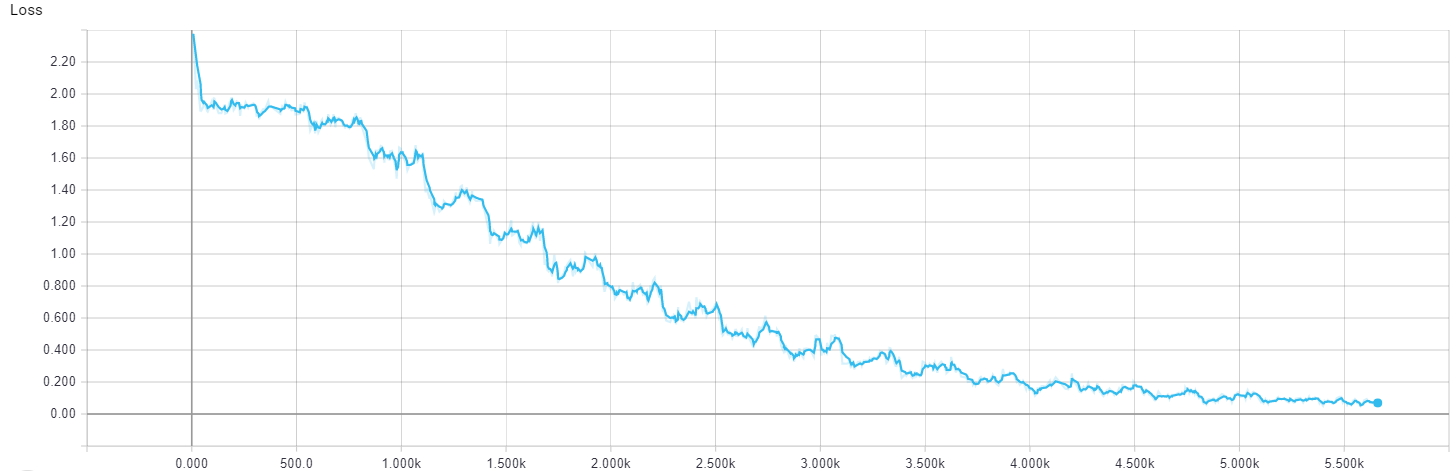

In [17]:
Image('PolarityLSTMloss.jpg')

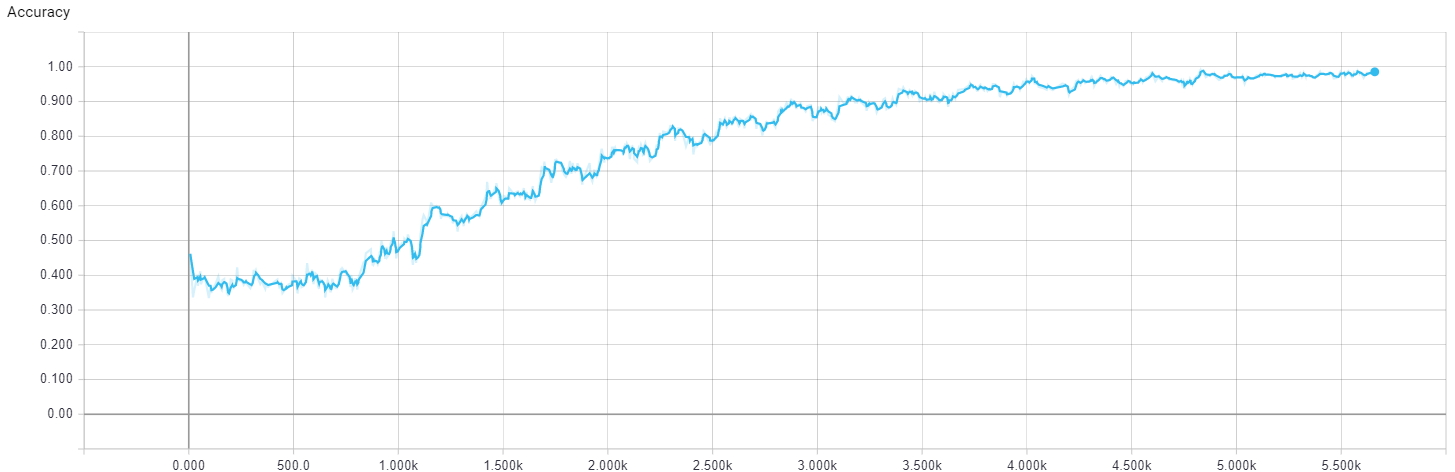

In [18]:
Image('PolarityLSTMaccuracy.jpg')

<p>As can be seen from the figures, PolarityLSTM performed extremely well on the train+test data, hitting even the 100% accuracy mark. Here are some arbitrary sentences that do not exist in the datasets used. All of them have the truth label negative (label: 0):</p>

In [2]:
def GetPolarity(sentence):
    sentencev = SentenceToVector(sentence)
    sentencev = sentencev.reshape(1, MAX_SENTENCE_LENGHT)
    prediction = LSTM_model.predict_label(sentencev)
    return prediction[0,0]

In [29]:
sentence = 'they turn in bad performances'
print('-', sentence, GetPolarity(sentence))
sentence = 'it was horrendous'
print('-', sentence, GetPolarity(sentence))
sentence = 'I would rather sleep on my couch than go see this movie'
print('-', sentence, GetPolarity(sentence))
sentence = 'There is so much wrong with it that you really just have \nto see it for yourself, although I would recommend not paying money for it. '
print('-', sentence, GetPolarity(sentence))
sentence = 'By the end of the night, hours after we left the theater, I felt totally gutted and crestfallen\n to realize what the Star Wars sequels had become, because Rian Johnson had to "Age of Ultron" the series'
print('-', sentence, GetPolarity(sentence))
sentence = 'I hated it'
print('-', sentence, GetPolarity(sentence))

- they turn in bad performances 0
- it was horrendous 0
- I would rather sleep on my couch than go see this movie 0
- There is so much wrong with it that you really just have 
to see it for yourself, although I would recommend not paying money for it.  0
- By the end of the night, hours after we left the theater, I felt totally gutted and crestfallen
 to realize what the Star Wars sequels had become, because Rian Johnson had to "Age of Ultron" the series 0
- I hated it 0


<p>So far so good. However, looking at the reviews, one key obsevation is that they often contain information or facts about the story, screenplay, plot etc. Following is an excerpt from a random review:</p>
<p>*"plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package ."*</p>
<p>As can clearly be seen from the first sentence on, the review is filled with factual information, which, by no means, are of this project's interest. Therefore, the need of a mechanism for filtering such as much as possible is obivous.</p>
<h4>3.1.2 Modification I: Addition of SubjectivityLSTM and the 3rd Respective Sentiment Map</h4>
<p>For the previosuly mentioned apparent need, another LSTM, that is reponsible of identifying subjectivity of sentences, was added to the model's LSTM module. From this point on, extracted sentences are first going to go through the SubjectivityLSTM, and if they are subjective, they are going to be fed into PolarityLSTM and the originally proposed workflow is going to take place. In addition to this, though, the respective index in the newly introduced third sentiment map (named as subjectivity/objectivity) will be set to `1`. If not, then nothing is going happen and the respective index in the third sentiment map is going to remain `0`. 
<br>The same network architecture and parameter values of PolarityLSTM were used for the SubjectivityLSTM as well. For training, the subjectivity/objectivity sentence dataset provided at [[6](http://www.cs.cornell.edu/people/pabo/movie-review-data/)] was used, which consists of 5000 objective and 5000 subjective sentences. The loss and accuracy plots obtained are very similar to that of PolartiyLSTM, and therefore are not included in the report. The only difference this time was the number of epoch used for training. In 8 epochs, SubjectivityLSTM was able to hit the 100% accuracy mark. Following is an example run where `1`: subjective and `0`: objective:</br></p>

In [4]:
tf.reset_default_graph()
tflearn.config.init_training_mode()
net = tflearn.input_data([None, MAX_SENTENCE_LENGHT])
net = tflearn.embedding(net, input_dim=NUM_DICTIONARY_WORDS+1, output_dim=100)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

SubjectivityLSTM_model = tflearn.DNN(net, tensorboard_verbose=0)
SubjectivityLSTM_model.load('model_subjectivity_lstm_2classes.tfl')

def GetSubjectivity(sentence):
    sentencev = SentenceToVector(sentence)
    sentencev = sentencev.reshape(1, MAX_SENTENCE_LENGHT)
    prediction = SubjectivityLSTM_model.predict_label(sentencev)
    return prediction[0,0]

sentence = "when she hears about her plan going awry , she collapses . "
print('-', sentence, GetSubjectivity(sentence))
sentence = "on its own , it's not very interesting . as a remake , it's a pale imitation . "
print('-', sentence, GetSubjectivity(sentence))
sentence = "this movie is about two girls finding themselves in a tornado"
print('-', sentence, GetSubjectivity(sentence))

INFO:tensorflow:Restoring parameters from C:\Users\seyit\NLP Lab\model_subjectivity_lstm_2classes.tfl
- when she hears about her plan going awry , she collapses .  0
- on its own , it's not very interesting . as a remake , it's a pale imitation .  1
- this movie is about two girls finding themselves in a tornado 0


<p>It is not expected from SubjectivityLSTM to be very robust, i. e., it is used as a vague filter to strip sentences down of obvious objective information. Through multiple arbitrarily introduced sentences, it was observed that it was *highly unlikely* for the SubjectiveLSTM to classify a subjective sentence as objective. However this is not true for the reverse case, meaning that SubjectivityLSTM would sometimes misclassify objective sentences as being subjective. But this is not a concern, as it is already good enough if it can filter as much as it can.</p>

<h4>3.1.3 Modification II: Particular Named Entity Stripping of Sentences</h4>
<p>Although PolarityLSTM performs extremely well on the training and test data, it seems that it can sometimes get confused. Following example demonstrates the confusion:</p>

In [8]:
tf.reset_default_graph()
tflearn.config.init_training_mode()
net = tflearn.input_data([None, MAX_SENTENCE_LENGHT])
net = tflearn.embedding(net, input_dim=NUM_DICTIONARY_WORDS+1, output_dim=100)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')

LSTM_model = tflearn.DNN(net, tensorboard_verbose=0)
LSTM_model.load('model_stanford_lstm_2classes.tfl')

sentence = 'djimon hounsou and anthony hopkins turn in excellent performances'
print('1. ', sentence, GetPolarity(sentence))
sentence = 'they turn in excellent performances'
print('2. ', sentence, GetPolarity(sentence))
sentence = 'and turn in excellent performances'
print('3. ', sentence, GetPolarity(sentence))

INFO:tensorflow:Restoring parameters from C:\Users\seyit\NLP Lab\model_stanford_lstm_2classes.tfl
1.  djimon hounsou and anthony hopkins turn in excellent performances 0
2.  they turn in excellent performances 1
3.  and turn in excellent performances 1


As can be seen, names create a confusion for the PolarityLSTM, especially when that name does not exist in the training set. Since many movie reviews often include names ranging from the director's to the actor's, and since names of people or organizations or names of any sort cannot have any sentimental value, the best option is to try to strip the sentences down of entites belonging to `PERSON` or `ORGANIZATION`. For this purpose, Stanford's NER Recognizer was used. However it must be noted that case sensitivity *definitely* affects the performance of this recognizer, and thus, the caseless version must be used. From this point on, every sentence fed to the model will be stripped down of the words that have been identified as belonging to the mentioned entities, right before the vectorization step. 

<h3>3.2 SentiWordNet Module</h3>
<p>As explained earlier, SentiWordNet was used as the reference point of determining the numerical sentimental value of a sentence. Each word in SentiWordNet is assigned a positive, negative and an objectivity score. For the scope of this project, only positive and negative scores will be used. This step is fairly straightforward, since NLTK already includes SentiWordNet. Following is an example run of the `GetAverageSentimentScore` function defined in `getsentimentscore.py`:</p>

In [16]:
sentence = "The Matrix was amazing"
print(sentence, '\n', 'positve score = ', GetSentenceAverageSentimentScore(sentence, 'pos'))
sentence = "I don't think I have ever seen more amazing movie than this"
print(sentence, '\n', 'positive score = ', GetSentenceAverageSentimentScore(sentence, 'pos'))
sentence = "This movie sucks monkey balls"
print(sentence, '\n', 'negative score = ', GetSentenceAverageSentimentScore(sentence, 'neg'))
sentence = "This movie is teribble."
print(sentence, '\n', 'negative score = ', GetSentenceAverageSentimentScore(sentence, 'neg'))

The Matrix was amazing 
 positve score =  0.25
I don't think I have ever seen more amazing movie than this 
 positive score =  0.975
This movie sucks monkey balls 
 negative score =  0.625
This movie is teribble. 
 negative score =  0.25


<h3>3.3 CNN Module</h3>
<p>CNN Module is the final step of the whole model. After every sentence in a review has gone through the LSTM and SentiWordNet modules, 3 sentiment maps of the review, namely positive, negative and objectivity/subjectivity are ready to be constructed. After the sentiment maps have been created, they are basically fed into the CNN, and then the review is labelled as either positive or negative. After sentiment map creation, the whole process is nothing but just an image classification task.</p>
<h4>3.3.1 Sentiment Map Construction</h4>

As also previously explained, sentiment maps of a given review is constructed based on the sentiment values of its sentences. Each review has three 10x10 sentiment maps. These are namely positive, negative and subjectivity/objectivity. `SENTIMENT_MAP_DIM` variable in the `constructsentimentmap.py` defines the maps' dimension. This ultimately means that any review up to 100 sentences long can be accommodated. After the sentiment score of the *i*th sentence is calculated, the value of the *i*th index in the respective polarity sentiment map is updated. If the *i*th sentence is objective, no alterations to the positive or negative sentiment maps are done, but just the objectivity/subjectivity map is updated. An example sentiment map construction is as follows: 

In [8]:
from constructsentimentmaps import ConstructSentimentMaps

text = "This film has a special place in my heart, as when I caught it the first time, I was teaching adult literacy. It rang very true to me and even an outstanding student I had at the time. There are scenes which make you gulp with sudden emotion, and those which even put a smile on your face through sheer identification with the characters and their situation. <br /><br />Excellent performances by Jane Fonda and Robert DeNiro that rank with their best work, a great turn by a young Martha Plimpton, an inspiring story line, and a haunting musical score makes for a most enjoyable and rewarding experience."

sentiment_map = ConstructSentimentMaps(text)
print(sentiment_map['pos'])
print(sentiment_map['neg'])
print(sentiment_map['so'])

[[ 68   0   0 186   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
[[  0 255   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]
[[  0   0 255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0

After the initial sentiment scores of all of the sentences are obtained, the non-zero values in each map are run through a softmax function (on their own domain), so as to scale/normalize the values accordingly. Since each map is meant to be thought of as 10x10 greyscale images, each entry on all of the maps are then multiplied by 255, as a pixel value on a greyscale image is on range [0, 255].

<h4>3.3.2 CNN Architecture and Training</h4>
The CNN network architecture used has of in total of 3 convolutional layers, 2 max pooling layers, 2 fully connected layers with a dropout layer in between, and 1 regression layer. As each review has 3 10x10 sentiment maps, these can be though of as channels of an image, i.e., each input data fed to the CNN has the shape (10, 10, 3). A sentiment map collection belonging to a review first goes through a convolution layer with `10x10` filter size that is followed by a max pooling one. After that, a second convolution is applied to the resulting generated filters, which also followed by another convolution layer. Both last two convolution layers have the filter size of `20x20`. Then, a second max pooling is applied, and the resulting data is passed to a fully connected layer with `128` neurons, which then passes the data to another fully connected layer, with a dropout rate of `0.3`this time. After this, the last step is a regressor layer, ultimately giving the result of the classification. The learning rate used was, again, `0.001`<br>
The dataset used for the training of the CNN module is provided at [[7](http://ai.stanford.edu/~amaas/data/sentiment/)]. It consists of 25,000 reviews for trainign and 25,000 reviews for testing. Each subset has 12,500 positive and 12,500 negative reviews. **As rich as this dataset is, a certain -and a very upsetting- drawback faced has to be mentioned**. Surprisingly, the most time demanding step of the entire project turned out to be the sentiment map construction during the preprocessing of data. It takes approximately 120 minutes to preporcess just 100 reviews. Therefore, any alteration intended to be made to the any of the previous steps of the model or any interruption of the preprocessing process unfortunately rendered the preprocessed dataset useless, and thus this yielded a never-ending cycle of days of data preparation. This was totally unforseen and definitely caused the loss of a very great deal of time. Due to this highly aggrovating complication, the training data had only 200 reviews.
<br>The following figures were obtained from `tensorboard` for the training of CNN module:

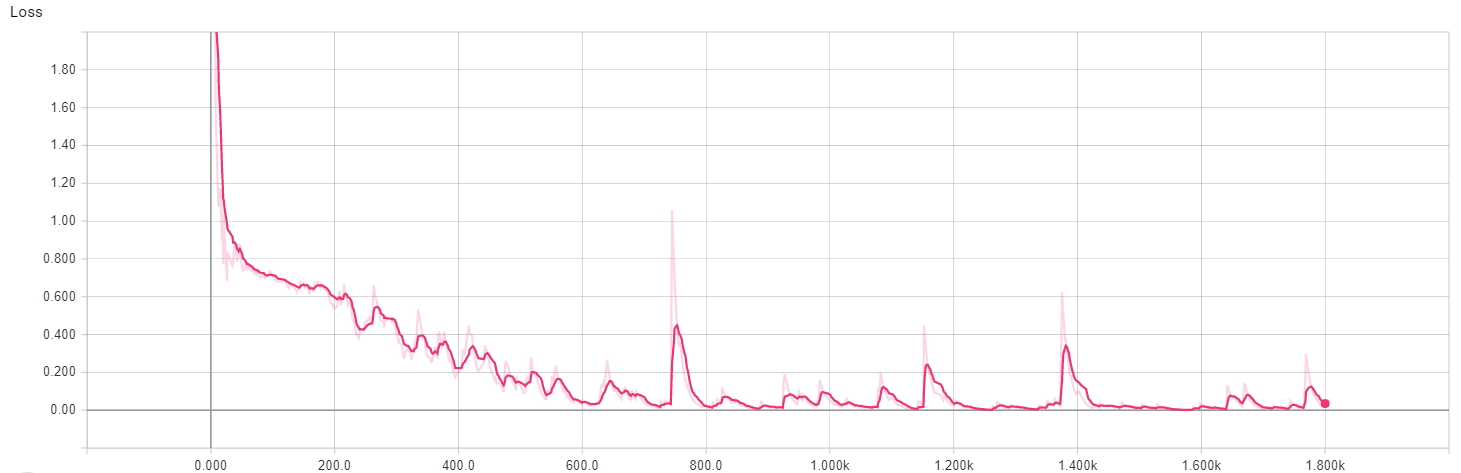

In [2]:
Image('CNNloss.jpg')

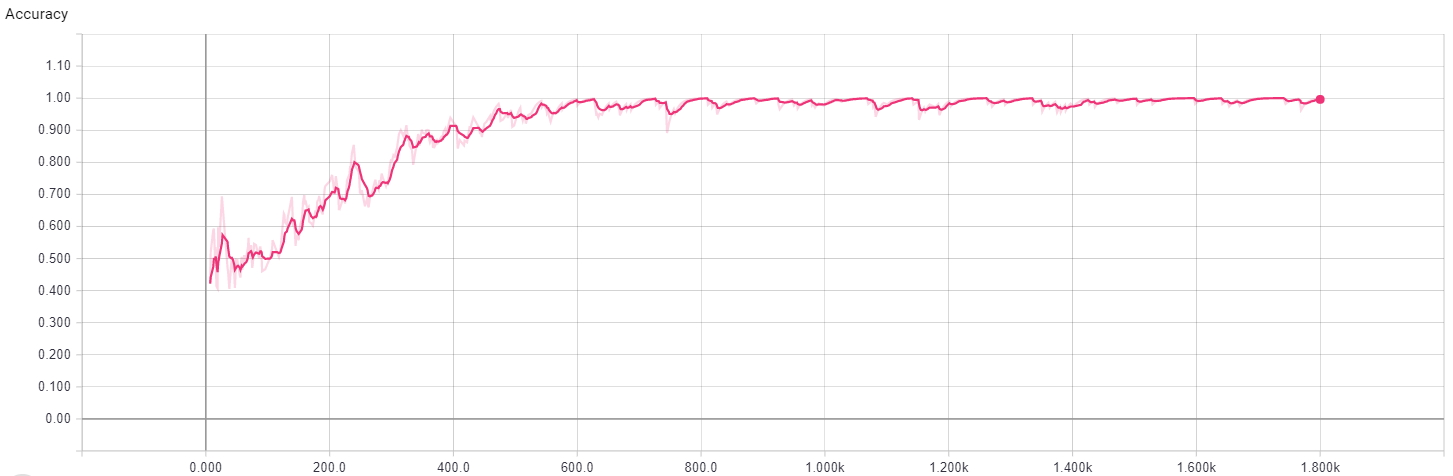

In [3]:
Image('CNNaccuracy.jpg')

In 50 epochs, CNN module hit the 100% accuracy mark.

<h2>4. Performance of the Model & Discussion</h2>
The model is *very* promising. Here are two arbitrarily selected review, noth of which has never been seen by the model in any step of any of the trainings:

In [11]:
from trainCNN import CNN_model
from constructsentimentmaps import ConstructSentimentMaps
import numpy as np
import tensorflow as tf
import tflearn

review_pos = """This film has a special place in my heart, as when I caught it the first time, I was teaching adult literacy. 
It rang very true to me and even an outstanding student I had at the time. 
There are scenes which make you gulp with sudden emotion, and those which even put a smile on your face through sheer identification with the characters and their situation. 
Excellent performances by Jane Fonda and Robert DeNiro that rank with their best work, a great turn by a young Martha Plimpton, 
an inspiring story line, and a haunting musical score makes for a most enjoyable and rewarding experience."""

review_neg ="""Rita Hayworth plays a Brooklyn nightclub dancer named Rusty who specializes in cheesecake chorus revues; she manages to get herself on the cover of a national fashion magazine, but her impending success as a solo (with romantic offers all around) has smitten boss Gene Kelly chomping at the bit. 
Terribly tired piece of Technicolor cotton candy, with unmemorable musical sketches (the two worst of which are irrelevant flashbacks to the 1890s, with Hayworth portraying her own grandmother). 
Kelly, as always, dances well but acts with false sincerity; when he's serious, he's insufferable, and the rest of the time he's flying on adrenaline. 
The script is a lead weight, not even giving supporting players Phil Silvers and Eve Arden any good lines. *1/2 from ****"""


def GetReviewPolarity(review):
    sentiment_map = ConstructSentimentMaps(review)
    map = np.dstack([sentiment_map['pos'], sentiment_map['neg'], sentiment_map['so']]).reshape([1, 10, 10, 3])
    prediction = CNN_model.predict_label(map)
    return prediction[0,0]

print(GetReviewPolarity(review_pos))
print(GetReviewPolarity(review_neg))

INFO:tensorflow:Restoring parameters from C:\Users\seyit\NLP Lab\model_CNN_2classes.tfl
1
0


Even this trial hints at the **promising potential of the entire model**. Of course, a complete test phase where hundreds of reviews are tested is needed, however, for that, the CNN module should have been introduced thousands of reviews for training. Which, unfortunately, would take weeks on the machine this project was implemented. Nevertheless, this is a definite futurework, and the model is definitely going to be explored more. 

<h2>5. Trials</h2>
In search of ways to aid the existing model, the idea of making use of probabilistic models was thought of. The first attempt was trying to utilize Restricted Boltzmann Machines (RBMs). An RBM is basically an unsupervised feature learning stochastic neural network that is capable of learning the underlying probability distribution of its input. The idea was to strip down every sentence of any words but the ones expressing an emotion, and then turn this occurences to probabilities. Also, the result obtained from the PolarityLSTM for the very sentence was also added to the training data as a feature, in order to see if an RBM would be capable of identifying the importance of a sentimental word appearing in a sentence. The training set used for this attempt was the same with that of PolarityLSTM. The optimization used was the maximization of negative log-likelihood. However, to be short, RBM did not perform well *at all*.  